In [1]:
# Install and import packages
!pip install pyGPGO

from pyGPGO.covfunc import matern32
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 6.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Connect to Google Colab
from google.colab import drive
from google.colab import output

# This will prompt for authorization to access your Google Drive from Colab.
drive.mount('/content/drive', force_remount=True)

# After mounting, you can navigate to a specific folder using the usual UNIX cd command.
# Replace 'your_folder_path' with the actual path of your folder inside Google Drive.
folder_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project'
package_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project/pyJive'
truss_path = '/content/drive/MyDrive/Colab Notebooks/Truss_project/truss_bridge'

# Support third party widgets
output.enable_custom_widget_manager()

Mounted at /content/drive


In [3]:
# importing ipympl and importing it (needs custom widgets enabled, that is why it is import seperatly)
!pip install ipympl

import ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00


In [4]:
# Manage standard path to the location of the geometry module python file
%cd "$package_path"

# Import geometry module
from geometrymodule import geometry

/content/drive/MyDrive/Colab Notebooks/Truss_project/pyJive


In [6]:
# Inititalize the geometry package
geom = geometry(package_path, truss_path)

# Defining governing parameters + setup for storage of tested variables
max_iterations = ### Define iterations
init_iterations = 20
vars = np.zeros((max_iterations + init_iterations, 19))
best_vars = np.zeros((max_iterations + init_iterations, 19))
best_score = -100000

it = 0

In [7]:
# Loss function
def f(x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14):
    geom.update_nodes([x1,x2,x3,x4,x5])
    geom.update_areas([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14])
    geom.compute_mass()
    frequency = geom.run_FEM(returns=True, prints=True)
    threshold = geom.FrequencyRequirements

    global it
    vars[it] = [x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14]

    mass_score = geom.mass
    frequency_score = 0
    check_score = 0
    for i in range(3):
        if frequency[i] < threshold[i]:
            frequency_score += (threshold[i] - frequency[i])**2 * 10
            check_score += 1000
        else:
            frequency_score += (threshold[i] - frequency[i])**2 * 2

    score = -mass_score - frequency_score - check_score
    global best_score
    global b_vars

    if score > best_score:
        b_vars = [x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14]
        best_score = score

    best_vars[it] = b_vars

    it += 1

    return -mass_score - frequency_score - check_score

# Storing the starting time
start_time = time.time()

# Setup the covariance matrix
cov = matern32()

# Setup the gaussian process
gp = GaussianProcess(cov)

# Setup the acquistion function
acq = Acquisition(mode='ExpectedImprovement')

#        Constraints for each parameter         "Optimal" solution
param = {'x1': ('cont', [0.6, 2.2]),            # 0.98
         'x2': ('cont', [0.6, 2.2]),            # 1.38
         'x3': ('cont', [0.6, 2.2]),            # 1.56
         'x4': ('cont', [0.6, 2.2]),            # 1.69
         'x5': ('cont', [0.6, 2.2]),            # 1.76
         'a1': ('cont', [0.00001, 0.001]),      # 0.00030
         'a2': ('cont', [0.00001, 0.001]),      # 0.00010
         'a3': ('cont', [0.00001, 0.001]),      # 0.00010
         'a4': ('cont', [0.00001, 0.001]),      # 0.00026
         'a5': ('cont', [0.00001, 0.001]),      # 0.00012
         'a6': ('cont', [0.00001, 0.001]),      # 0.00011
         'a7': ('cont', [0.00001, 0.001]),      # 0.00023
         'a8': ('cont', [0.00001, 0.001]),      # 0.00015
         'a9': ('cont', [0.00001, 0.001]),      # 0.00015
         'a10': ('cont', [0.00001, 0.001]),     # 0.00023
         'a11': ('cont', [0.00001, 0.001]),     # 0.00012
         'a12': ('cont', [0.00001, 0.001]),     # 0.00012
         'a13': ('cont', [0.00001, 0.001]),     # 0.00025
         'a14': ('cont', [0.00001, 0.001]),     # 0.00010
         }

# Define random seed
np.random.seed(50)

# Initialize the bayesian optimizer
gpgo = GPGO(gp, acq, f, param)

# Run the bayesian optimizer
gpgo.run(max_iter=max_iterations, init_evals=init_iterations)

# Compute total run time
run_time = time.time() - start_time

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Smallest three natural frequencies: [18.14057015 50.93375802 93.03615654] Hz
Smallest three natural frequencies: [15.56418685 46.53746777 74.64907028] Hz
Smallest three natural frequencies: [15.16341322 39.79706805 88.18102535] Hz
Smallest three natural frequencies: [12.82650879 45.88294625 92.0915715 ] Hz
Smallest three natural frequencies: [ 9.00264957 29.49780993 72.95979385] Hz
Smallest three natural frequencies: [ 9.20551199 36.6760687  50.56581911] Hz
Smallest three natural frequencies: [ 4.78045494 14.52069098 37.28043019] Hz
Smallest three natural frequencies: [16.21228431 35.37167827 62.16771465] Hz
Smallest three natural frequencies: [ 4.82942202 32.95118919 47.18321717] Hz
Smallest three natural frequencies: [ 4.07896218 23.96444058 63.13784503] Hz
Smallest three natural frequencies: [ 6.43758575 29.43756696 78.40617712] Hz
Smallest three natural frequencies: [ 5.919423   20.17311762 31.89562779] Hz
Smallest three nat

The best score found by the optimizer is 2119.70
The total mass of the structure is 436.400 kg
The model took 77.15 seconds to run
Smallest three natural frequencies: [13.83437932 49.36501114 67.34173691] Hz


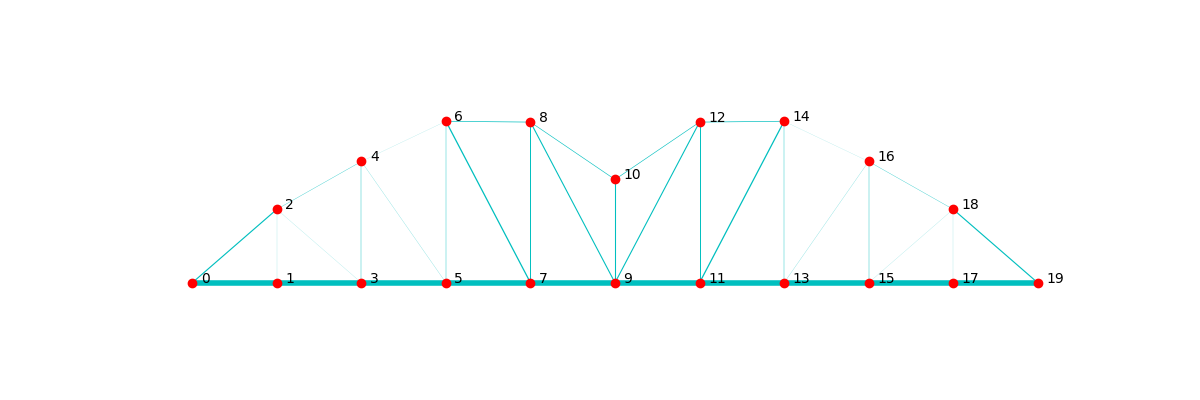

In [8]:
# Acquire optimal result from optimizer
x1, x2, x3, x4, x5 = (gpgo.getResult()[0].get(key) for key in ['x1', 'x2', 'x3', 'x4', 'x5'])
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14  = (gpgo.getResult()[0].get(key) for key in ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14'])

# Update geometry
geom.update_nodes((x1, x2, x3, x4, x5))
geom.update_areas((a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14))

# Print summary
print(f"The best score found by the optimizer is {-gpgo.getResult()[1]:.2f}")
geom.print_mass()
print(f"The model took {run_time:.2f} seconds to run")
geom.run_FEM(prints=True)
geom.plot_structure()

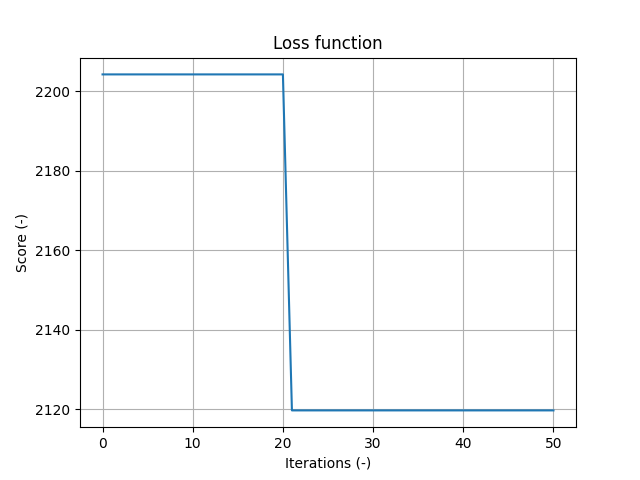

In [9]:
#Plotting the objective function
best_eval = gpgo.history
iterations = np.linspace(0, max_iterations, max_iterations+1)
plt.figure()
plt.plot(iterations, [-x for x in best_eval])
plt.grid()
plt.title("Loss function")
plt.xlabel("Iterations (-)")
plt.ylabel("Score (-)")
plt.show()

In [10]:
# Displaying optimal variables
df = pd.DataFrame(gpgo.getResult()[0], index=[0]).round(5)
df

,x1,x2,x3,x4,x5,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14
0,0.86871,1.43462,1.90995,1.90004,1.22112,0.00082,0.00009,0.00008,0.00022,0.00029,0.00013,0.00007,0.00028,0.0009,0.0005,0.0007,0.00078,0.00043,0.00077


In [29]:
# Setup for animation
x_locs = geom.nodes["x"]
y_locs = geom.nodes["y"]
node_map = geom.members[["Node 1", "Node 2"]]
x_map = node_map.replace(np.linspace(0, 19, 20), x_locs).to_numpy().T
y_list1 = np.zeros((2, 37))
y_list2 = np.zeros((2, 37))

# Looping through each iteration
for i in range(len(vars)):
    # Storing each iteration to y_list1
    y_locs[[2, 4, 6, 8, 10, 12, 14, 16, 18]] = [vars[i][0], vars[i][1], vars[i][2], vars[i][3], vars[i][4], vars[i][3], vars[i][2], vars[i][1], vars[i][0]]
    y_map1 = node_map.replace(np.linspace(0, 19, 20), y_locs)
    y_list1 = np.append(y_list1, y_map1.T, axis=0)

    # Storing the best iteration to y_list2
    y_locs[[2, 4, 6, 8, 10, 12, 14, 16, 18]] = [best_vars[i][0], best_vars[i][1], best_vars[i][2], best_vars[i][3], best_vars[i][4], best_vars[i][3], best_vars[i][2], best_vars[i][1], best_vars[i][0]]
    y_map2 = node_map.replace(np.linspace(0, 19, 20), y_locs)
    y_list2 = np.append(y_list2, y_map2.T, axis=0)

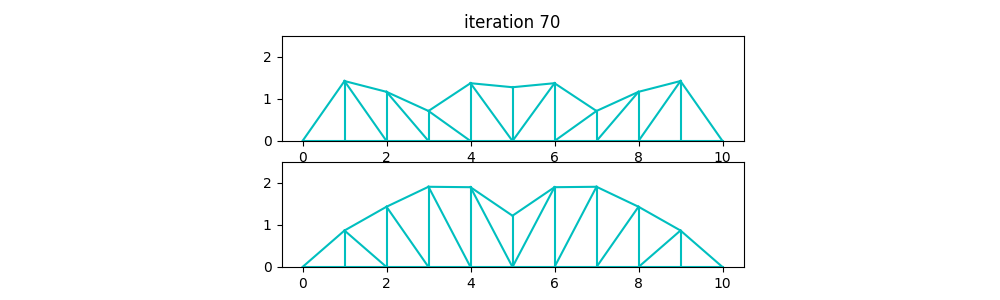

In [34]:
from matplotlib.animation import FuncAnimation
%matplotlib widget

# Initialize the animiation
fig, ax = plt.subplots(2, 1, figsize=(10, 3))
ax[0].set_ylim(0, 2.5)
ax[0].set_aspect("equal")
ax[1].set_ylim(0, 2.5)
ax[1].set_aspect("equal")

line1 = ax[0].plot(x_map, y_list1[2:4], "c-")
line2 = ax[1].plot(x_map, y_list2[2:4], "c-")

# Construct animate function (defines what needs to be updated with each frame)
def animate(i):
    ax[0].set_title(f"iteration {i+1}")
    for j in range(37):
      line1[j].set_ydata(y_list1[2*(i+1):2*(i+2), j])
      line2[j].set_ydata(y_list2[2*(i+1):2*(i+2), j])

    return line1, line2

# Create animation
ani = FuncAnimation(fig=fig, func=animate, frames=(init_iterations + max_iterations), interval=50).save(f"{max_iterations}_iteration_animation.mp4", dpi=600)
plt.show()